##Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/Data_mining/Lab2/Notebooks
!ls

/content/drive/My Drive/Data_mining/Lab2/Notebooks
Decision_Tree.ipynb  Load_Dataset.ipynb  Naive_Bayes.ipynb  RunAndPlot.ipynb


#Installing Packages

In [3]:
!pip install ipynb

##Importing Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
import csv
import time
import re
import tracemalloc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from ipynb.fs.full.Load_Dataset import load_dataset, get_dataset_names
from ipynb.fs.full.Decision_Tree import makeTree, predictDataDecisionTree
from ipynb.fs.full.Naive_Bayes import predictDataNaiveBayes

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Installing Packages

In [5]:
!pip install ipynb

In [6]:
randomState = 123
path = '/content/drive/My Drive/Data_mining/Lab2'

## Dataset Load

In [7]:
def precalculation(X, Y, threshold= 10):
  attrMeans = {}
  attrStds = {}
  classes= np.unique(Y)
  attrInfo = []

  for i in range(X.shape[1]):
    attrInfoDict = {}
    values = np.unique(X[:,i])
    if values.shape[0]>threshold:
      attrInfoDict['type']= 'continuous'
      attrInfoDict['values']= None
    else:
      attrInfoDict['type']= 'discrete'
      attrInfoDict['values']= values
    attrInfo.append(attrInfoDict) 

  for i in range(classes.shape[0]):
    cls = classes[i]
    projX, projY = X[Y==cls], Y[Y==cls]
    attrMeans[cls], attrStds[cls] = [], []
    for j in range(X.shape[1]):
      attrInfoDict = attrInfo[j]
      if attrInfoDict['type']=='continuous': 
        attrMeans[cls].append(np.mean(projX[:,j]))
        attrStds[cls].append(np.std(projX[:,j]))
      else:
        attrMeans[cls].append(None)
        attrStds[cls].append(None)
  cache={
      'attrInfo': attrInfo,
      'attrMeans': attrMeans,
      'attrStds': attrStds
  }
  return cache

In [8]:
def plotBarChart(dTreeMeasures, nBayesMeasures):
  plt.clf()
  # set width of bar 
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8)) 
    
  # Set position of bar on X axis 
  br1 = np.arange(len(dTreeMeasures)) 
  br2 = [x + barWidth for x in br1] 
    
  # Make the plot 
  plt.bar(br1, dTreeMeasures, color ='#273c75', width = barWidth, 
          edgecolor ='grey', label ='Decision Tree') 
  plt.bar(br2, nBayesMeasures, color ='#7f8fa6', width = barWidth, 
          edgecolor ='grey', label ='Naive Bayes') 
    
  # Adding Xticks  
  plt.xlabel('Measures', fontweight ='bold', fontsize = 15) 
  plt.ylabel('Scores', fontweight ='bold', fontsize = 15) 
  plt.xticks([r + barWidth for r in range(len(dTreeMeasures))], 
            ['Accuracy', 'Precision', 'Recall', 'F1-score']) 
  plt.title('Dataset = {}'.format(datasetName))  
  plt.legend()
  plt.ylim(0,1.1)
  plt.show() 

In [9]:
def saveBarChart(datasetName, dTreeMeasures, nBayesMeasures, fileExtension ='png'):
  plt.clf()
  # set width of bar 
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8)) 
    
  # Set position of bar on X axis 
  br1 = np.arange(len(dTreeMeasures)) 
  br2 = [x + barWidth for x in br1] 
  
  # Make the plot 
  plt.bar(br1, dTreeMeasures, color ='#273c75', width = barWidth, 
          edgecolor ='grey', label ='Decision Tree') 
  plt.bar(br2, nBayesMeasures, color ='#7f8fa6', width = barWidth, 
          edgecolor ='grey', label ='Naive Bayes') 
    
  # Adding Xticks  
  plt.xlabel('Measures', fontweight ='bold', fontsize = 15) 
  plt.ylabel('Scores', fontweight ='bold', fontsize = 15) 
  plt.xticks([r + barWidth for r in range(len(dTreeMeasures))], 
            ['Accuracy', 'Precision', 'Recall', 'F1-score']) 
  plt.title('Dataset = {}'.format(datasetName))  
  plt.legend()
  plt.ylim(0,1.1)
  plt.savefig('{}/Plots/{}.{}'.format(path, datasetName, fileExtension))

In [10]:
def runClassification(datasetName, threshold=10, numOfIter = 10, numSplit= 5, testSize = 0.2):
  X, Y = load_dataset(datasetName)

  kFold = KFold(n_splits=numSplit)
  numOfsplits = kFold.get_n_splits(X)
  YActual = np.array([])
  YPredDTree = np.array([])
  YPredNBayes = np.array([])

  for i in range(numOfIter):
    XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size= testSize, stratify=Y, random_state = 123 + i)  

  # for trainIndex, testIndex in kFold.split(X):
  #   # print("TRAIN:", trainIndex, "TEST:", testIndex)
  #   XTrain, XTest, YTrain, YTest = X[trainIndex], X[testIndex], Y[trainIndex], Y[testIndex]
    YActual = np.append(YActual, YTest)

    cache = precalculation(XTrain, YTrain, threshold)

    # print(X, Y)
    # print(trainSize, testSize)
    # print(attrInfo)

    # Decision Tree
    root = None
    marker = np.ones((X.shape[1]))
    root = makeTree( XTrain, YTrain, marker, cache, selectionMeasure = 'gain')
    YPredDTree = np.append(YPredDTree,predictDataDecisionTree(root, XTest))
    
    # Naive Bayes
    YPredNBayes = np.append(YPredNBayes, predictDataNaiveBayes(XTrain, YTrain, XTest , cache))

  print('Decision Tree')
  precisionDTree, recallDTree, f1scoreDTree, _ = precision_recall_fscore_support(YActual, YPredDTree, average= 'macro')
  accuracyDTree = accuracy_score(YActual, YPredDTree)
  print('Mismatch = ',np.sum(YActual!=YPredDTree))
  print('mismatched indices: ',[i for i in range(YActual.shape[0]) if YActual[i]!=YPredDTree[i]])
  print('precisionDTree = {}, recallDTree= {}, f1scoreDTree={}, accuracyDTree = {}'.format(precisionDTree, recallDTree, f1scoreDTree, accuracyDTree))

  print('Naive Bayes')
  precisionNBayes, recallNBayes, f1scoreNBayes, _ = precision_recall_fscore_support(YActual, YPredNBayes, average = 'macro')
  accuracyNBayes = accuracy_score(YActual, YPredNBayes)
  print('Mismatch = ',np.sum(YActual!=YPredNBayes))
  print('mismatched indices: ',[i for i in range(YActual.shape[0]) if YActual[i]!=YPredNBayes[i]])
  print('precisionNBayes = {}, recallNBayes= {}, f1scoreNBayes={}, accuracyNBayes = {}'.format(precisionNBayes, recallNBayes, f1scoreNBayes, accuracyNBayes))

  dTreeMeasures = [accuracyDTree, precisionDTree, recallDTree, f1scoreDTree]
  nBayesMeasures = [accuracyNBayes, precisionNBayes, recallNBayes, f1scoreNBayes]

  plotBarChart(dTreeMeasures, nBayesMeasures)
  saveBarChart(datasetName, dTreeMeasures, nBayesMeasures, fileExtension ='png')
  # saveBarChart(datasetName, dTreeMeasures, nBayesMeasures, fileExtension ='svg')
  print('********************************************************************************')


['iris', 'wine', 'australian', 'breastTissue', 'parkinsons', 'pima', 'sonar', 'heart', 'ionosphere', 'ecoli']
iris
dataset: iris
instances = 150, features= 4 
Decision Tree
Mismatch =  18
mismatched indices:  [7, 15, 40, 47, 60, 64, 83, 119, 132, 142, 144, 150, 171, 255, 281, 283, 286, 292]
precisionDTree = 0.9407378335949764, recallDTree= 0.94, f1scoreDTree=0.9401861754802932, accuracyDTree = 0.94
Naive Bayes
Mismatch =  14
mismatched indices:  [11, 40, 47, 54, 60, 64, 83, 105, 142, 150, 171, 190, 204, 274]
precisionNBayes = 0.9534480458850206, recallNBayes= 0.9533333333333333, f1scoreNBayes=0.9533286661999533, accuracyNBayes = 0.9533333333333334


<Figure size 432x288 with 0 Axes>

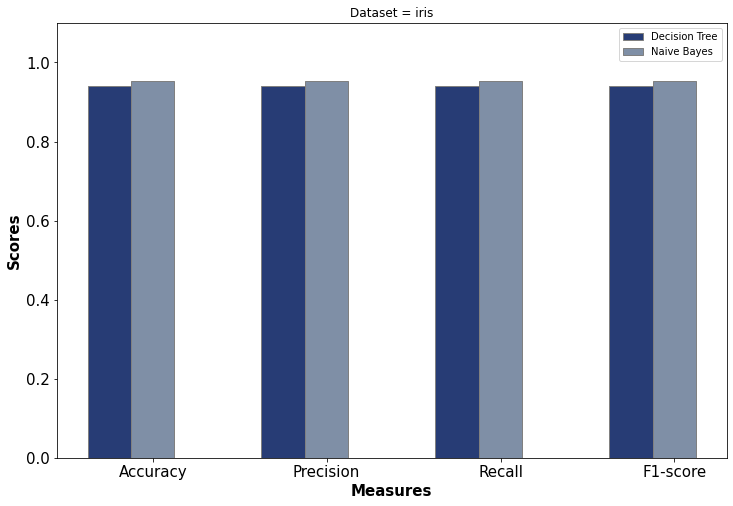

********************************************************************************
wine
dataset: wine
instances = 178, features= 13 
Decision Tree
Mismatch =  19
mismatched indices:  [8, 16, 71, 79, 127, 154, 156, 187, 242, 245, 269, 290, 308, 319, 320, 327, 342, 350, 351]
precisionDTree = 0.9477301095876948, recallDTree= 0.9508730158730159, f1scoreDTree=0.9489338258786632, accuracyDTree = 0.9472222222222222
Naive Bayes
Mismatch =  8
mismatched indices:  [101, 178, 256, 282, 289, 290, 315, 325]
precisionNBayes = 0.9771082516108308, recallNBayes= 0.9797619047619047, f1scoreNBayes=0.9782694852521344, accuracyNBayes = 0.9777777777777777


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

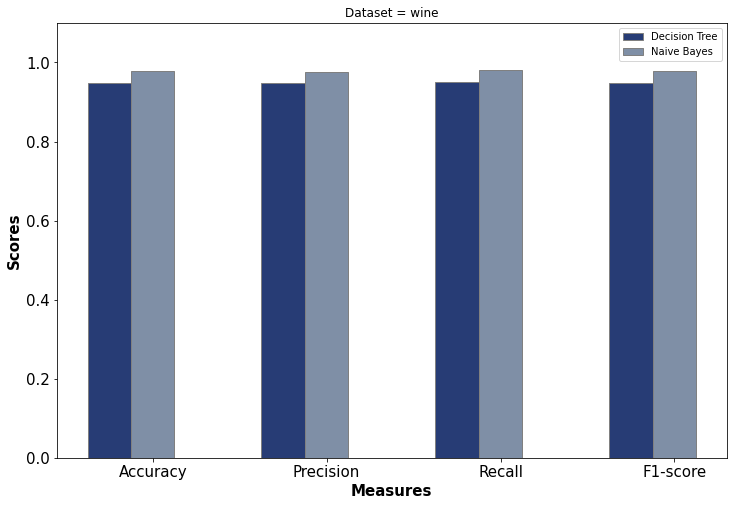

********************************************************************************
australian
dataset: australian
instances = 690, features= 14 
Decision Tree
Mismatch =  266
mismatched indices:  [17, 22, 29, 30, 42, 43, 47, 48, 66, 67, 69, 71, 73, 80, 81, 86, 100, 102, 111, 121, 130, 135, 137, 143, 145, 156, 163, 166, 169, 178, 181, 199, 202, 205, 211, 214, 221, 223, 230, 241, 247, 248, 249, 256, 258, 259, 264, 271, 275, 282, 297, 298, 301, 303, 315, 318, 322, 333, 340, 346, 347, 349, 352, 353, 359, 362, 367, 368, 371, 372, 376, 383, 387, 399, 400, 407, 409, 412, 432, 443, 453, 454, 458, 465, 466, 467, 468, 471, 476, 483, 489, 497, 506, 509, 510, 515, 516, 517, 532, 534, 536, 546, 552, 558, 569, 573, 579, 587, 590, 594, 595, 599, 600, 604, 610, 611, 612, 619, 627, 636, 638, 656, 661, 662, 665, 666, 670, 672, 678, 679, 683, 690, 692, 693, 696, 697, 705, 710, 713, 715, 719, 721, 724, 725, 732, 734, 736, 737, 740, 744, 746, 748, 758, 759, 779, 792, 793, 805, 817, 825, 831, 845, 846, 847, 8

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

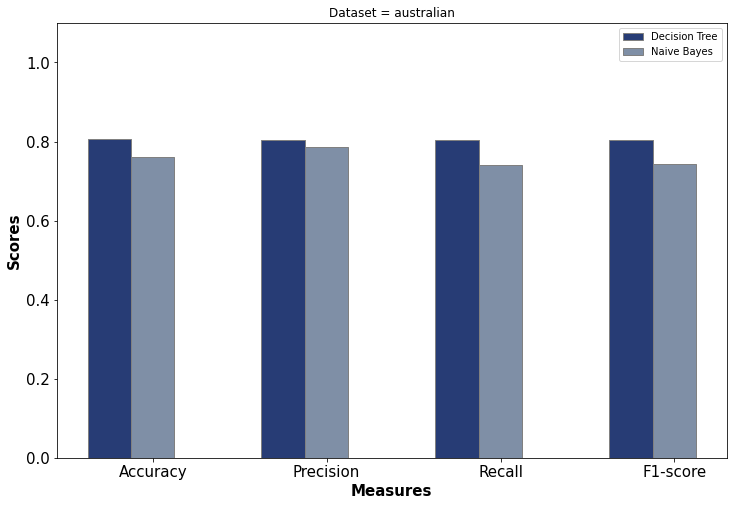

********************************************************************************
breastTissue
dataset: breastTissue
instances = 106, features= 9 
Decision Tree
Mismatch =  67
mismatched indices:  [8, 9, 11, 12, 14, 16, 19, 21, 26, 28, 29, 31, 32, 35, 41, 42, 46, 51, 53, 56, 62, 66, 68, 69, 76, 78, 82, 88, 98, 104, 113, 116, 118, 121, 124, 125, 129, 134, 137, 139, 141, 143, 145, 146, 153, 154, 155, 161, 163, 164, 167, 182, 186, 189, 190, 191, 193, 194, 196, 197, 199, 202, 203, 204, 206, 208, 210]
precisionDTree = 0.660598644853964, recallDTree= 0.6866666666666666, f1scoreDTree=0.6676141706890041, accuracyDTree = 0.6954545454545454
Naive Bayes
Mismatch =  76
mismatched indices:  [4, 8, 9, 10, 11, 12, 16, 19, 21, 26, 31, 32, 34, 42, 46, 47, 48, 53, 56, 58, 62, 65, 66, 73, 75, 76, 77, 78, 82, 87, 90, 92, 97, 98, 102, 104, 105, 107, 113, 116, 118, 121, 122, 125, 128, 129, 133, 135, 137, 141, 145, 146, 153, 154, 155, 164, 167, 168, 172, 181, 182, 186, 191, 192, 194, 196, 197, 198, 202, 203, 

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

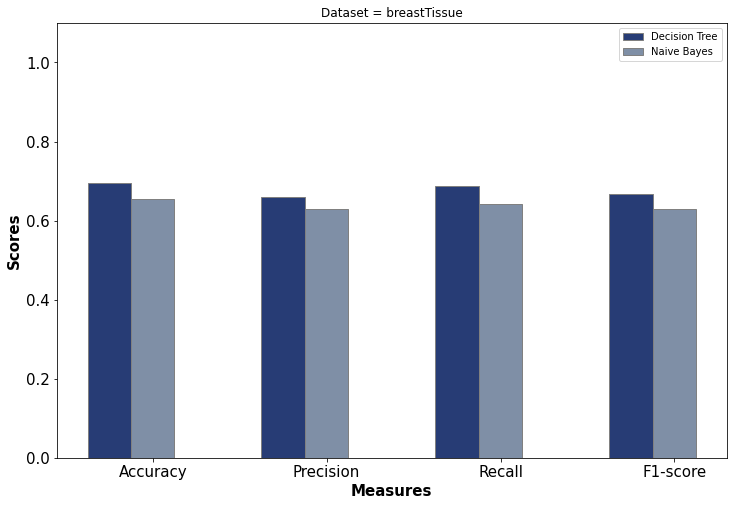

********************************************************************************
parkinsons
dataset: parkinsons
instances = 195, features= 22 
Decision Tree
Mismatch =  51
mismatched indices:  [18, 25, 39, 46, 47, 78, 87, 95, 117, 122, 124, 128, 130, 132, 141, 161, 162, 184, 194, 195, 199, 210, 212, 217, 218, 221, 237, 238, 241, 244, 252, 271, 273, 274, 277, 291, 297, 309, 315, 332, 333, 336, 338, 340, 341, 342, 354, 359, 366, 375, 389]
precisionDTree = 0.8256167233578812, recallDTree= 0.8400000000000001, f1scoreDTree=0.8323089764018514, accuracyDTree = 0.8692307692307693
Naive Bayes
Mismatch =  114
mismatched indices:  [0, 2, 7, 9, 13, 19, 20, 22, 24, 32, 36, 40, 42, 47, 50, 51, 53, 67, 69, 70, 71, 82, 85, 87, 90, 91, 92, 95, 98, 99, 105, 110, 118, 119, 121, 122, 126, 133, 136, 139, 148, 161, 162, 164, 166, 168, 171, 173, 175, 176, 179, 182, 189, 192, 193, 195, 199, 204, 205, 210, 212, 215, 218, 219, 221, 232, 234, 237, 242, 243, 247, 248, 251, 254, 262, 265, 269, 273, 277, 279, 280, 

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

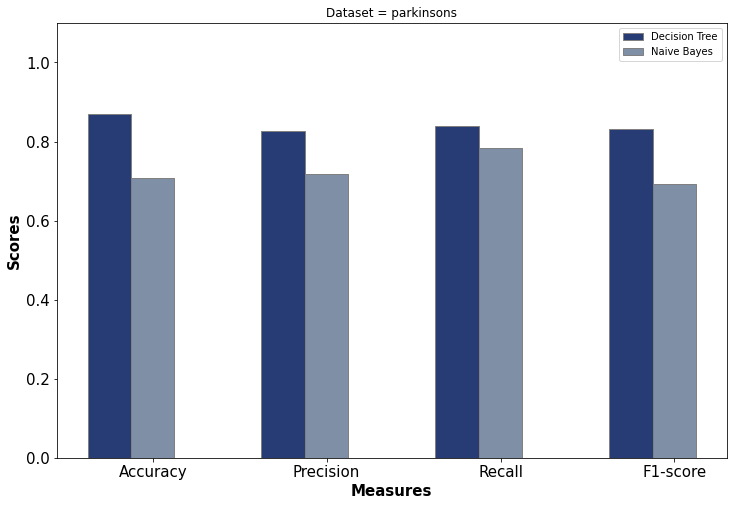

********************************************************************************
pima
dataset: pima
instances = 768, features= 8 
Decision Tree
Mismatch =  441
mismatched indices:  [0, 1, 2, 4, 5, 8, 9, 15, 21, 23, 28, 32, 36, 37, 41, 42, 43, 49, 50, 51, 52, 53, 62, 64, 73, 78, 79, 83, 87, 89, 91, 92, 93, 102, 104, 105, 106, 124, 127, 129, 146, 150, 151, 162, 165, 167, 168, 169, 170, 172, 173, 182, 184, 189, 195, 201, 203, 204, 207, 216, 218, 220, 221, 228, 232, 234, 235, 237, 239, 242, 243, 245, 247, 249, 252, 259, 262, 266, 270, 274, 278, 284, 291, 293, 294, 298, 309, 313, 316, 320, 322, 324, 328, 337, 349, 351, 354, 357, 358, 361, 363, 364, 366, 374, 378, 382, 385, 388, 390, 395, 397, 399, 401, 409, 413, 415, 419, 421, 431, 435, 437, 440, 444, 446, 449, 452, 458, 462, 463, 465, 471, 473, 482, 487, 488, 490, 495, 500, 501, 503, 504, 505, 510, 511, 512, 517, 518, 523, 526, 532, 534, 535, 537, 538, 539, 543, 546, 547, 552, 553, 556, 559, 561, 563, 565, 570, 573, 582, 584, 587, 590, 591

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

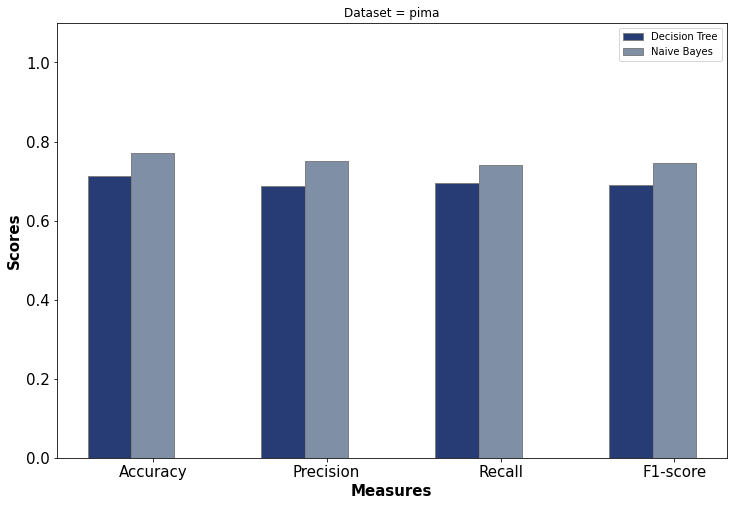

********************************************************************************
sonar
dataset: sonar
instances = 208, features= 60 
Decision Tree
Mismatch =  123
mismatched indices:  [1, 7, 13, 16, 19, 25, 33, 35, 39, 43, 48, 51, 63, 65, 66, 68, 70, 81, 87, 91, 92, 93, 94, 99, 107, 110, 111, 113, 114, 116, 118, 125, 126, 127, 129, 132, 135, 136, 138, 141, 143, 147, 154, 157, 164, 167, 168, 171, 173, 175, 180, 182, 185, 191, 199, 202, 208, 209, 210, 220, 222, 224, 229, 230, 232, 233, 234, 237, 240, 242, 243, 253, 259, 261, 262, 267, 270, 271, 273, 275, 277, 283, 287, 289, 293, 295, 297, 300, 303, 313, 315, 317, 323, 324, 325, 328, 343, 346, 347, 349, 350, 354, 359, 360, 367, 368, 370, 375, 378, 385, 386, 387, 388, 391, 393, 394, 396, 401, 402, 409, 410, 411, 415]
precisionDTree = 0.7064957264957265, recallDTree= 0.7059090909090909, f1scoreDTree=0.7061015502773431, accuracyDTree = 0.7071428571428572
Naive Bayes
Mismatch =  139
mismatched indices:  [5, 7, 8, 9, 13, 18, 21, 25, 28, 29, 35

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

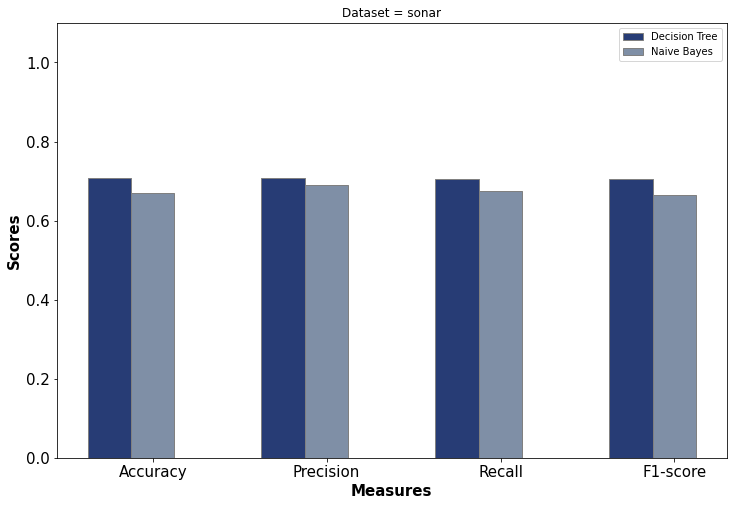

********************************************************************************
heart
dataset: heart
instances = 270, features= 13 
Decision Tree
Mismatch =  140
mismatched indices:  [1, 2, 6, 9, 11, 13, 14, 15, 17, 18, 23, 24, 27, 31, 43, 44, 50, 52, 54, 55, 57, 60, 62, 63, 65, 66, 78, 79, 81, 82, 83, 84, 87, 96, 105, 111, 115, 119, 122, 124, 127, 130, 140, 143, 147, 153, 154, 162, 166, 181, 182, 183, 185, 188, 194, 198, 202, 204, 206, 216, 218, 227, 228, 230, 236, 238, 239, 241, 242, 243, 246, 252, 257, 264, 272, 273, 282, 290, 291, 297, 299, 304, 305, 307, 309, 335, 341, 344, 348, 349, 351, 354, 363, 370, 374, 376, 386, 389, 399, 405, 406, 407, 408, 417, 419, 420, 423, 425, 432, 433, 437, 446, 448, 450, 452, 461, 468, 469, 477, 480, 485, 486, 487, 488, 491, 492, 495, 496, 498, 499, 503, 511, 513, 514, 516, 517, 518, 520, 525, 537]
precisionDTree = 0.7380952380952381, recallDTree= 0.74, f1scoreDTree=0.7386759581881532, accuracyDTree = 0.7407407407407407
Naive Bayes
Mismatch =  88
mi

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

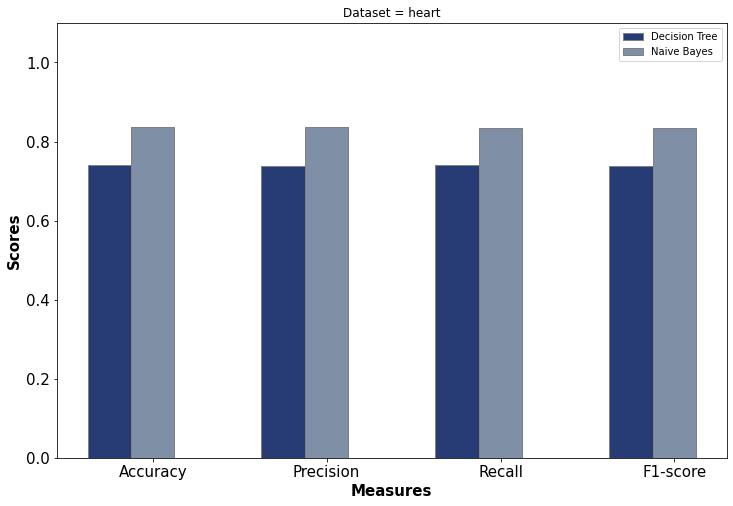

********************************************************************************
ionosphere
dataset: ionosphere
instances = 351, features= 34 
Decision Tree
Mismatch =  81
mismatched indices:  [1, 17, 29, 33, 38, 42, 46, 48, 53, 62, 71, 90, 99, 100, 101, 113, 131, 139, 151, 163, 165, 175, 176, 178, 182, 212, 218, 219, 222, 223, 226, 238, 246, 264, 282, 287, 291, 300, 308, 318, 326, 330, 336, 339, 341, 343, 352, 353, 374, 375, 387, 397, 399, 404, 407, 408, 421, 429, 442, 452, 473, 493, 494, 502, 513, 518, 521, 544, 545, 551, 558, 566, 580, 609, 624, 641, 653, 684, 690, 692, 707]
precisionDTree = 0.8792609182530795, recallDTree= 0.8681304347826087, f1scoreDTree=0.8731793373394344, accuracyDTree = 0.8859154929577465
Naive Bayes
Mismatch =  129
mismatched indices:  [2, 7, 17, 29, 30, 35, 36, 39, 41, 46, 47, 53, 62, 71, 73, 75, 78, 89, 90, 95, 96, 99, 101, 113, 120, 123, 124, 125, 129, 131, 150, 162, 163, 165, 175, 178, 179, 185, 202, 203, 216, 218, 219, 220, 224, 226, 228, 252, 256, 260, 2

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

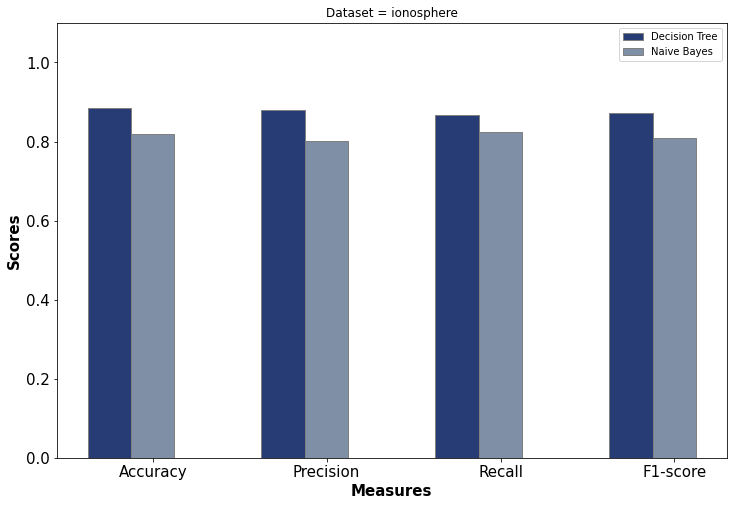

********************************************************************************
ecoli
dataset: ecoli
instances = 336, features= 7 
Decision Tree
Mismatch =  131
mismatched indices:  [0, 6, 11, 14, 20, 27, 29, 33, 36, 39, 43, 47, 51, 57, 58, 61, 62, 64, 72, 76, 77, 80, 88, 91, 93, 95, 108, 118, 119, 124, 139, 148, 162, 170, 178, 179, 181, 182, 184, 202, 205, 207, 209, 213, 215, 220, 227, 228, 230, 231, 253, 254, 257, 262, 263, 275, 282, 294, 297, 305, 310, 313, 318, 321, 328, 329, 331, 332, 334, 337, 340, 353, 355, 358, 366, 368, 387, 394, 395, 399, 401, 403, 404, 412, 415, 430, 432, 433, 436, 441, 442, 452, 457, 464, 477, 487, 489, 491, 505, 513, 514, 515, 519, 521, 533, 537, 538, 540, 547, 552, 553, 559, 560, 566, 569, 578, 581, 595, 610, 615, 619, 625, 632, 642, 647, 652, 658, 659, 664, 670, 679]
precisionDTree = 0.562424228147107, recallDTree= 0.5201785014554411, f1scoreDTree=0.5384054407701311, accuracyDTree = 0.8073529411764706
Naive Bayes
Mismatch =  99
mismatched indices:  [4, 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

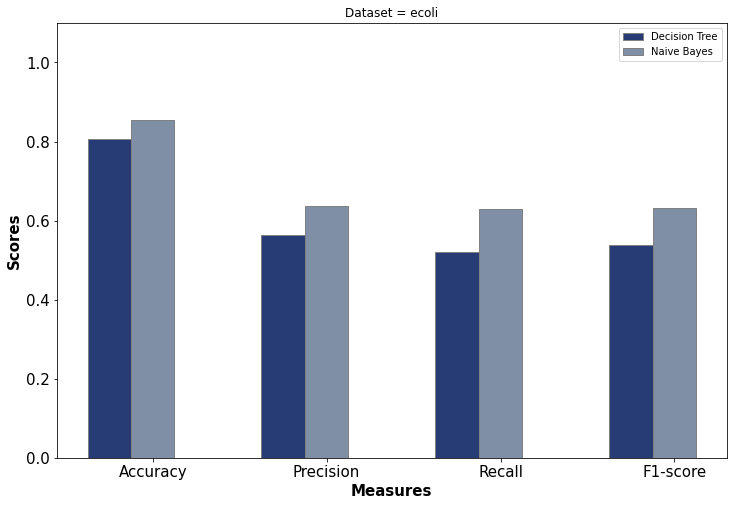

********************************************************************************


<Figure size 432x288 with 0 Axes>

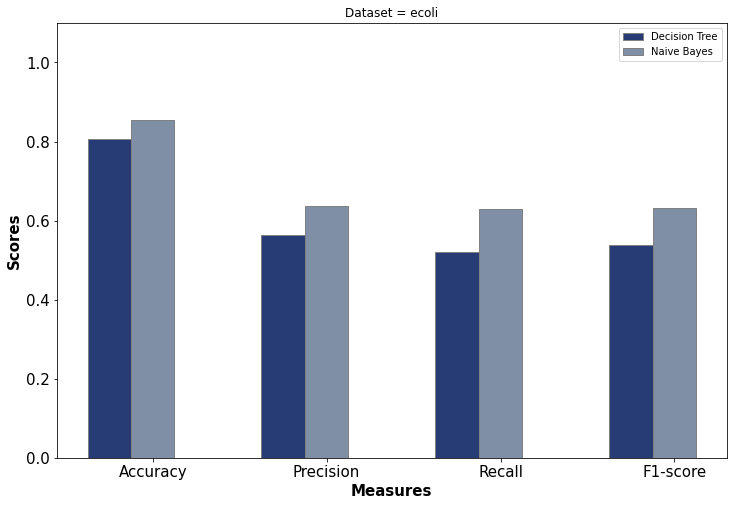

In [11]:
# datasetNames = get_dataset_names()
datasetNames = ['iris'  ,'wine' ,'australian' ,'breastTissue', 'parkinsons', 'pima' ,'sonar', 'heart' , 'ionosphere', 'ecoli' ]
print(datasetNames)
for datasetName in datasetNames:
  print(datasetName)
  runClassification(datasetName, threshold=15, numOfIter=10, numSplit=5, testSize = 0.2)